In [6]:
import pickle
import numpy as np
import pandas as pd

DATA = {
    "X" : [],
    "category" : [],
    "y" : [],
    "topic":[]
}

X=DATA["X"]
category=DATA["category"]
y=DATA["y"]
topic = DATA["topic"]

with open('covid_fake_news_BERTEmbeddings.pickle', 'rb') as handle:
    dst = pickle.load(handle)
    X.extend(dst)
    category.extend(np.repeat(0,len(dst)))
    data = pd.read_csv("raw/covid_fake_news.csv",sep="\t")
    y.extend(1-data["label"].values)
    
#     with open('covid_fake_news_categories.pickle', 'rb') as handle:
#         top=pickle.load(handle)
#         topic.extend(top)
    
with open('mmcovid_en_BERTEmbeddings.pickle', 'rb') as handle:
    dst = pickle.load(handle)
    X.extend(dst)
    category.extend(np.repeat(1,len(dst)))
    data = pd.read_csv("raw/mmcovid_en.csv",sep=",")
    y.extend(data["label"].values)
    

with open('pubhealth_BERTEmbeddings.pickle', 'rb') as handle:
    dst = pickle.load(handle)
    X.extend(dst)
    category.extend(np.repeat(2,len(dst)))
    data = pd.read_csv("raw/pubhealth.csv",sep=",")
    y.extend(data["label"].values)

    with open('pubhealth_categories.pickle', 'rb') as handle:
        top=pickle.load(handle)
        topic.extend(top)

    
with open('qprop_BERTEmbeddings.pickle', 'rb') as handle:
    dst = pickle.load(handle)
    X.extend(dst)
    category.extend(np.repeat(3,len(dst)))
    data = pd.read_csv("raw/qprop.csv",sep="\t")
    y.extend(data["label"].values)
    
with open('isot_BERTEmbeddings.pickle', 'rb') as handle:
    dst = pickle.load(handle)
    X.extend(dst)
    category.extend(np.repeat(4,len(dst)))
    data = pd.read_csv("raw/isot.csv",sep=",")
    y.extend(data["label"].values)
    
with open('grafn_BERTEmbeddings.pickle', 'rb') as handle:
    dst = pickle.load(handle)
    X.extend(dst)
    category.extend(np.repeat(5,len(dst)))
    data = pd.read_csv("raw/grafn.csv",sep=",")
    y.extend(data["label"].values)
    
    
DATA["X"]=np.array(X)
DATA["category"]=np.array(category)
DATA["y"]=np.array(y)
DATA["folds"] = []
DATA["topic"] = np.array(topic)

/tmp/ipykernel_3903/1890039292.py:66: DtypeWarning: Columns (2,4,5,8,9,10,11,12,13,15,21) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("raw/grafn.csv",sep=",")


In [2]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from imblearn.metrics import geometric_mean_score
from IPython.display import clear_output

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

def experiment(foldids, X, y, cls = LogisticRegression(max_iter=10000), fit=True):

    scores = {
        'Accuracy': {'func': accuracy_score},
        'Balanced Accuracy': {'func': balanced_accuracy_score},
        'F1': {'func': f1_score},
        'Precision': {'func': precision_score},
        'Recall': {'func': recall_score},
        'G-mean': {'func': geometric_mean_score}
    }

    for score_name, score_dict in scores.items():
        scores[score_name]["list"] = []
        scores[score_name]["lab"] = []

    for fold,j in enumerate(foldids):
        train = foldids[fold][1]
        test = foldids[fold][2]
        xin, yin = X[train], np.array(y[train])
        
        pca = PCA(n_components=128)
        pca.fit(xin)
        
        
        if fit == True:
            cls.fit(pca.transform(xin), yin)
        y_pred = cls.predict(pca.transform(X[test]))
        for score_name, score_dict in scores.items():
            if score_name in ["F1","Precision","Recall"]:
                scorvaln = score_dict['func'](y[test], y_pred, average=None)
                score_dict['lab'].append(scorvaln)
                scorval = score_dict['func'](y[test], y_pred, average="weighted")
                score_dict['list'].append(scorval)
                #print(score_name, scorval, scorvaln)  
            else:
                scorval=score_dict['func'](y[test], y_pred)
                score_dict['list'].append(scorval)
                #print(score_name, scorval)
        #print(" ")

    #clear_output()
    for score_name, score_dict in scores.items():
        score_dict['avg'] = np.mean(score_dict['list'])
        score_dict['std'] = np.std(score_dict['list'])
 
    # Print stats
    numlabels = scores["F1"]["lab"][0].shape[0]
    scores["F1"]["lab"][0].shape[0] 
    head = "| %-20s | %-10s |" +  numlabels * " %-10s |" 
    headv = ["Score", "Average"]
    headv.extend(["Kat_"+str(i+1) for i in range(numlabels)])
    row=head % tuple(headv)
    print("+"*len(row))
    print(row)
    print("+"*len(row))
    for score_name, score_dict in sorted(scores.items()) :
        headv = [score_name, np.mean(score_dict['list'])*100, np.std(score_dict['list'])*100]
        for i in range(numlabels):
            if score_name in ["F1","Precision","Recall"]:
                head = "| %-20s | %4.1f ± %3.1f |" + numlabels* " %4.1f ± %3.1f |"
                vals = [v[i] for v in scores[score_name]["lab"]]
                headv.append(np.mean(vals)*100)
                headv.append(np.std(vals)*100)
            else:
                head = "| %-20s | %4.1f ± %3.1f |" + numlabels * " %-10s |" 
                headv.append("-")
        print(head % tuple(headv))
    print("+"*len(row))
    return cls, scores, pca

<hr style="border: 5px dashed red">

# Topic aware

In [11]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.decomposition import PCA

t=2
X = DATA["X"][DATA["category"] == t]
y = DATA["y"][DATA["category"] == t]
topics = DATA["topic"]
foldids = []

print(X.shape, y.shape, topics.shape)

rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1410)

for fold_idx, (train, test) in enumerate(rskf.split(X, y)):
    foldids.append((fold_idx,train,test))
    
for _foldid in range(10):
    print("fold",_foldid) 
    trainX = X[foldids[_foldid][1]]
    trainY = y[foldids[_foldid][1]]
    
    testX = X[foldids[_foldid][2]]
    testY = y[foldids[_foldid][2]]
    
    pca = PCA(n_components=512)
    pca.fit(trainX)
    
    lr = LogisticRegression(max_iter=10000, class_weight='balanced')
    lr.fit(pca.transform(trainX), trainY)
    
    scr = balanced_accuracy_score(testY, lr.predict(pca.transform(testX)))
    print(scr)

(10075, 768) (10075,) (10075,)
fold 0
0.818501347291662
fold 1
0.8200985412740065
fold 2
0.8165088867408496
fold 3
0.8222537528710903
fold 4
0.8245502367750472
fold 5
0.8148326030612842
fold 6
0.8131444012312807
fold 7
0.8149755262908038
fold 8
0.8145225674508132
fold 9
0.8136773490417578


In [12]:

for _foldid in range(10):
    print("fold",_foldid)
    train_topics = topics[foldids[_foldid][1]]
    test_topics = topics[foldids[_foldid][2]]
    
    trainX = X[foldids[_foldid][1]]
    trainY = y[foldids[_foldid][1]]
    
    testX = X[foldids[_foldid][2]]
    testY = y[foldids[_foldid][2]]
    
    pca = PCA(n_components=512)
    pca.fit(trainX)

    cls = {}
    #print(np.unique(train_topics,return_counts=True))
    for topic in np.unique(train_topics):
        cls[topic] = LogisticRegression(max_iter=10000, class_weight='balanced')
        this_topic = train_topics==topic
        if len(np.unique(trainY[this_topic])) > 1:
            cls[topic].fit(pca.transform(trainX[this_topic]), trainY[this_topic])
        else:
            #print(trainY[this_topic])
            cls[topic] = np.max(trainY[this_topic])
    
    pred = []
    gt = []
    #print(np.unique(test_topics,return_counts=True))
    for topic in np.unique(test_topics):
        this_topic = test_topics==topic
        gt.extend(testY[this_topic])
        
        if topic in cls:
            #print(topic, len(testX[this_topic]))
            if isinstance( cls[topic], LogisticRegression):
                pr = cls[topic].predict(pca.transform(testX[this_topic]))
                pred.extend(pr)
            else:
                pred.extend(np.repeat(cls[topic],len(testX[this_topic])))
        else:
            print("uknown [",topic,"] len=",len(testX[this_topic]), testY[this_topic])
            pred.extend(np.repeat(1,len(testX[this_topic])))
    #test = foldids[2]
    scr = balanced_accuracy_score(gt, pred)
    print(scr)
    

fold 0
0.7993570184094807
fold 1
uknown [ Finance ] len= 1 [0]
0.7991259461719806
fold 2
0.7983736595436455
fold 3
uknown [ Finance ] len= 1 [0]
0.8025111560923678
fold 4
0.8009370890928684
fold 5
uknown [ Finance ] len= 1 [0]
0.7951031370386308
fold 6
uknown [ Finance ] len= 1 [0]
0.7964911527987744
fold 7
0.802006632041873
fold 8
0.7949544074482557
fold 9
uknown [ Finance ] len= 1 [0]
0.7952197987560123


# KNN


In [16]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.decomposition import PCA


## Import libraries
from nltk.cluster import KMeansClusterer
import nltk


t=2
X = DATA["X"][DATA["category"] == t]
y = DATA["y"][DATA["category"] == t]
topics = DATA["topic"]
foldids = []

print(X.shape, y.shape, topics.shape)

rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1410)

for fold_idx, (train, test) in enumerate(rskf.split(X, y)):
    foldids.append((fold_idx,train,test))
    
for _foldid in range(10):
    print("fold",_foldid) 
    trainX = X[foldids[_foldid][1]]
    trainY = y[foldids[_foldid][1]]
    
    testX = X[foldids[_foldid][2]]
    testY = y[foldids[_foldid][2]]
    
    pca = PCA(n_components=64)
    pca.fit(trainX)
    
    trainX_PCA = pca.transform(testX)
    
    kclusterer = KMeansClusterer(
    15, distance=nltk.cluster.util.cosine_distance,
    repeats=3,avoid_empty_clusters=True)
    
    assigned_clusters = kclusterer.cluster(trainX_PCA, assign_clusters=True)
    
    lr = LogisticRegression(max_iter=10000, class_weight='balanced')
    lr.fit(pca.transform(trainX), trainY)
    
    scr = balanced_accuracy_score(testY, lr.predict(pca.transform(testX)))
    print(scr)

(10075, 768) (10075,) (10075,)
fold 0
0.7950116137130148
fold 1


KeyboardInterrupt: 

# Single Task Performance

In [28]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.decomposition import PCA

DATA["folds"] = []
rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1410)

stl=[]

for t in range(np.max(DATA["category"]+1)):
    print("TASK",t)
    X = DATA["X"][DATA["category"] == t]
    y = DATA["y"][DATA["category"] == t]

    foldids = []
    for fold_idx, (train, test) in enumerate(rskf.split(X, y)):
        foldids.append((fold_idx,train,test))

    #print("shapes X",X.shape,"y", y.shape)
    DATA["folds"].append(foldids)
    model1, scores1, pca = experiment(foldids, X, y, 
                                 LogisticRegression(max_iter=10000, class_weight='balanced'))
    stl.append((model1,pca,scores1))

TASK 0
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Score                | Average    | Kat_1      | Kat_2      |
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Accuracy             | 91.8 ± 0.3 | -          | -          |
| Balanced Accuracy    | 89.1 ± 0.8 | -          | -          |
| F1                   | 93.3 ± 0.2 | 52.0 ± 1.0 | 95.5 ± 0.2 |
| G-mean               | 89.0 ± 0.8 | -          | -          |
| Precision            | 96.0 ± 0.1 | 37.3 ± 1.0 | 99.2 ± 0.1 |
| Recall               | 91.8 ± 0.3 | 86.0 ± 1.7 | 92.2 ± 0.4 |
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
TASK 1
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Score                | Average    | Kat_1      | Kat_2      |
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Accuracy             | 87.3 ± 1.4 | -          | -          |
| Balanced Accuracy    | 88.6 ± 0.6 | -          | -          |
| F1                   | 8

In [29]:
#
# Checking how it generalises...
#

T = np.max(DATA["category"])+1
d = 128

stl_bacs = [[] for b in range(T)]

ft = 0

for ft in range(6):
    print("STL-",ft)
    for _foldid in range(10):
        #print("fold",_foldid)

        ##### Test
        for task in range(T):
            X = DATA["X"][DATA["category"] == task]
            y = DATA["y"][DATA["category"] == task]
            foldids = DATA["folds"][task]

            train = foldids[_foldid][1]
            test = foldids[_foldid][2]    

            X=stl[ft][1].transform(X[test])

            #print(np.unique(domain_pred, return_counts=True))
            #print("task",task, pred_task_id)

            pred=stl[ft][0].predict(X)
            bac = balanced_accuracy_score(y[test], pred)
            #print(task,bac)
            stl_bacs[task].append(bac)
            


STL- 0
STL- 1
STL- 2
STL- 3
STL- 4
STL- 5


In [30]:
stl_corrmat = [[] for b in range(T)]
for c in range(6):
    print(f"STL-{c}")
    for rr in range(T):
        mm = np.mean(stl_bacs[c][rr*10:(rr*10+10)])
        stl_corrmat[c].append(mm)
        print(f"  task_{rr}",mm)

STL-0
  task_0 0.927078494361103
  task_1 0.5414514857642718
  task_2 0.45064045055821367
  task_3 0.5044609576031202
  task_4 0.6221134462217128
  task_5 0.6154223300948131
STL-1
  task_0 0.5584537069265576
  task_1 0.8964206984568976
  task_2 0.4517635456549483
  task_3 0.5139227288548556
  task_4 0.5084479057895348
  task_5 0.5204635108481261
STL-2
  task_0 0.48362146553791147
  task_1 0.45311070009156484
  task_2 0.8153233839041322
  task_3 0.3093158920830715
  task_4 0.3593799253764745
  task_5 0.3620544166877425
STL-3
  task_0 0.44193302930744843
  task_1 0.5122527526903893
  task_2 0.2623859811041931
  task_3 0.8689419493052505
  task_4 0.6658130468693861
  task_5 0.7668446820647884
STL-4
  task_0 0.46337201645076886
  task_1 0.5152162833268753
  task_2 0.20535026784605206
  task_3 0.8003166607955983
  task_4 0.9930449164452314
  task_5 0.6713233124290622
STL-5
  task_0 0.4844049735132777
  task_1 0.4973487618519837
  task_2 0.3464135896097048
  task_3 0.7270570722438792
  task_

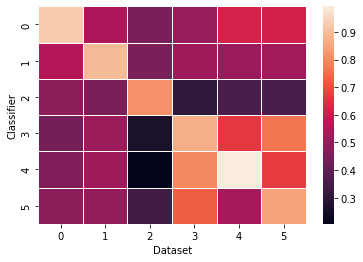

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt

uniform_data = np.array(stl_corrmat)
ax = sns.heatmap(uniform_data, linewidth=0.5)
ax.set(xlabel='Dataset', ylabel='Classifier')
plt.show()

In [32]:
for t in range(T):
    print("%3.1f ± %3.2f &" % (np.mean(stl_bacs[t])*100, 100*np.std(stl_bacs[t])) )

print("---")
print(np.mean(np.array(stl_bacs).flatten())*100, np.std(np.array(stl_bacs).flatten())*100)

61.0 ± 15.41 &
57.5 ± 14.72 &
46.4 ± 16.80 &
58.6 ± 20.42 &
60.8 ± 25.20 &
57.3 ± 16.72 &
---
56.93192533915356 19.209019709861153


/tmp/ipykernel_4317/2081165960.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


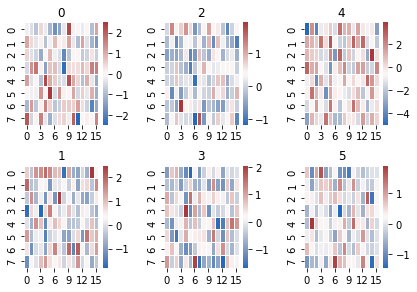

In [33]:
fig, ax = plt.subplots(2, 3, gridspec_kw={'height_ratios': [1, 1]} )
fig.tight_layout(w_pad=1, h_pad=2)


for c in range(6):
    ob=sns.heatmap(stl[c][0].coef_.reshape((8,16)), linewidth=0.5, cmap="vlag", ax = ax[c%2, int(c/2)])
    ob.set_title(str(c))
    #ax.set(xlabel='Task ID', ylabel='Classifier')

fig.show()

# Batch Multi Task Performance

In [15]:
X = DATA["X"]
y = DATA["y"]

rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1410)
foldids = []
for fold_idx, (train, test) in tqdm(enumerate(rskf.split(X, y)), total=rskf.get_n_splits()):
    foldids.append((fold_idx,train,test))
    
print("shapes X",X.shape,"y", y.shape)

model3, scores3, model3_pca = experiment(foldids, X, y, 
                             LogisticRegression(max_iter=10000))

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 168.25it/s]


shapes X (186477, 768) y (186477,)
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Score                | Average    | Kat_1      | Kat_2      |
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Accuracy             | 84.5 ± 0.1 | -          | -          |
| Balanced Accuracy    | 77.7 ± 0.2 | -          | -          |
| F1                   | 84.0 ± 0.1 | 89.7 ± 0.1 | 68.8 ± 0.3 |
| G-mean               | 76.2 ± 0.2 | -          | -          |
| Precision            | 84.0 ± 0.1 | 86.8 ± 0.1 | 76.3 ± 0.3 |
| Recall               | 84.5 ± 0.1 | 92.6 ± 0.1 | 62.7 ± 0.4 |
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++


In [16]:
T = np.max(DATA["category"])+1
d = 128

_bacs = [[] for b in range(T)]


for _foldid in range(10):
    print("fold",_foldid)

    ##### Test
    for task in range(T):
        X = DATA["X"][DATA["category"] == task]
        y = DATA["y"][DATA["category"] == task]
        foldids = DATA["folds"][task]
        
        train = foldids[_foldid][1]
        test = foldids[_foldid][2]    
        
        X=model3_pca.transform(X[test])

        #print(np.unique(domain_pred, return_counts=True))
        #print("task",task, pred_task_id)

        pred=model3.predict(X)
        bac = balanced_accuracy_score(y[test], pred)
        print(task,bac)
        _bacs[task].append(bac)



fold 0
0 0.49765548381824126
1 0.6721197354681518
2 0.4339265959496282
3 0.7679134383557792
4 0.8952621559899304
5 0.7428387681433037
fold 1
0 0.4999364129798912
1 0.6956868546235062
2 0.4249617692986762
3 0.7677087313301036
4 0.8935283859855814
5 0.7425453827469328
fold 2
0 0.5048238803530566
1 0.6872752059403643
2 0.42634382142896204
3 0.7684364509080804
4 0.8939748618681436
5 0.7422696008095576
fold 3
0 0.49280601889297543
1 0.6805313841512937
2 0.4325480636175031
3 0.7671857187778024
4 0.8948158564585218
5 0.7431143494494806
fold 4
0 0.4950708973520758
1 0.6895086436941641
2 0.4326003360026786
3 0.7640519852469432
4 0.8960918276382196
5 0.7423266474346388
fold 5
0 0.5025216068694329
1 0.678297946397494
2 0.42628873320525795
3 0.7715701844389397
4 0.8926986853548489
5 0.7430574684888602
fold 6
0 0.4972448103955541
1 0.6831563986541362
2 0.4274510150326286
3 0.7681316990954206
4 0.8953432193606389
5 0.7442298479058739
fold 7
0 0.5003571047049308
1 0.6846501914375218
2 0.4314412923896

In [17]:
for t in range(T):
    print("%3.1f ± %3.2f &" % (np.mean(_bacs[t])*100, 100*np.std(_bacs[t])) )

print("---")
print(np.mean(np.array(_bacs).flatten())*100, np.std(np.array(_bacs).flatten())*100)

49.9 ± 0.36 &
68.4 ± 0.60 &
42.9 ± 0.30 &
76.8 ± 0.20 &
89.4 ± 0.10 &
74.3 ± 0.09 &
---
66.95081148935634 15.94969569409529


<hr style="border: 5px dashed red">

# Domain Classifier

In [18]:
X = DATA["X"]
y = DATA["y"]
category = DATA["category"]

rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=5, random_state=1410)
foldids = []
for fold_idx, (train, test) in enumerate(rskf.split(X, y)):
    foldids.append((fold_idx,train,test))
    
print("shapes X",X.shape,"y", category.shape)

domain_model, domain_scores, domain_pca = experiment(foldids, X, 
                                         category, LogisticRegression(max_iter=10000, class_weight='balanced'))

shapes X (186477, 768) y (186477,)
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Score                | Average    | Kat_1      | Kat_2      | Kat_3      | Kat_4      | Kat_5      | Kat_6      |
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
| Accuracy             | 71.2 ± 0.3 | -          | -          | -          | -          | -          | -          |
| Balanced Accuracy    | 79.9 ± 0.2 | -          | -          | -          | -          | -          | -          |
| F1                   | 71.2 ± 0.3 | 94.7 ± 0.2 | 77.2 ± 0.4 | 64.0 ± 0.2 | 64.0 ± 0.2 | 76.4 ± 0.6 | 70.3 ± 0.3 |
| G-mean               | 78.8 ± 0.2 | -          | -          | -          | -          | -          | -          |
| Precision            | 72.3 ± 0.3 | 92.2 ± 0.3 | 67.5 ± 0.6 | 51.1 ± 0.3 | 65.8 ± 0.3 | 72.8 ± 0.6 | 78.2 ± 0.5 |
| Recall               | 71.2 ± 0.3 |

<hr style="border: 5px dashed red">

# ParamMultitaskShare

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SparseNet(nn.Module):

    def __init__(self, K:int=32, M:int=128, R_lr:float=0.1, lmda:float=5e-3, device=None):
        super(SparseNet, self).__init__()
        self.K = K
        self.M = M
        self.R_lr = R_lr
        self.lmda = lmda
        # synaptic weights
        self.device = torch.device("cpu") if device is None else device
        self.U = nn.Linear(self.K, self.M, bias=False).to(self.device)
        # responses
        self.R = None
        self.normalize_weights()

    def ista_(self, img_batch):
        # create R
        self.R = torch.zeros((img_batch.shape[0], self.K), requires_grad=True, device=self.device)
        converged = False
        # update R
        optim = torch.optim.SGD([{'params': self.R, "lr": self.R_lr}])
        # train
        while not converged:
            old_R = self.R.clone().detach()
            # pred
            pred = self.U(self.R)
            # loss
            loss = ((img_batch - pred) ** 2).sum()
            loss.backward()
            # update R in place
            optim.step()
            # zero grad
            self.zero_grad()
            # prox
            self.R.data = SparseNet.soft_thresholding_(self.R, self.lmda)
            # convergence
            converged = torch.norm(self.R - old_R) / torch.norm(old_R) < 0.01

    @staticmethod
    def soft_thresholding_(x, alpha):
        with torch.no_grad():
            rtn = F.relu(x - alpha) - F.relu(-x - alpha)
        return rtn.data

    def zero_grad(self):
        self.R.grad.zero_()
        self.U.zero_grad()

    def normalize_weights(self):
        with torch.no_grad():
            self.U.weight.data = F.normalize(self.U.weight.data, dim=0)

    def forward(self, img_batch):
        # first fit
        self.ista_(img_batch)
        # now predict again
        pred = self.U(self.R)
        return pred, self.R



In [20]:
thetas = np.array([stl[ft][0].coef_[0] for ft in range(T)])
snet = SparseNet( K=40, M=128)

#print(thetas_T.shape)

thetas_T = torch.tensor(thetas)
optim = torch.optim.SGD([{'params': snet.U.weight, "lr": 1e-2}])

running_loss = 0
code = None
coverged = False
for c in range(350):
    pred, code = snet.forward(thetas_T)
    loss = ((thetas_T - pred) ** 2).sum()
    running_loss += loss.item()
    loss.backward()
    optim.step()
    snet.zero_grad()
    snet.normalize_weights()

print('Loss', running_loss / (c+1))


Loss 1.8569289592231761


In [21]:
pred, code = snet.forward(thetas_T)


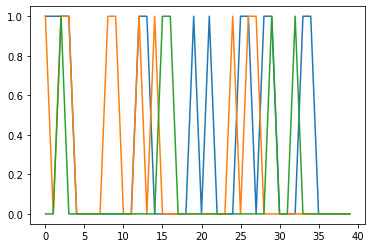

In [23]:
for t in [0,1,2]:
    y = [1 if v > 0.5 else 0 for v in code[t].detach().numpy()]
    plt.plot(y)

/tmp/ipykernel_4317/24245997.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


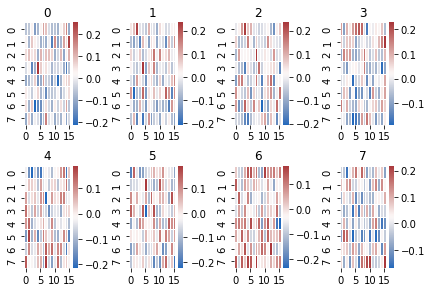

In [25]:
uw = snet.U.weight.detach().numpy().T

fig, ax = plt.subplots(2, 4)
fig.tight_layout(w_pad=1, h_pad=2)


for c in range(8):
    ob=sns.heatmap(uw[c].reshape((8,16)), linewidth=0.5, cmap="vlag", ax = ax[int(c/4), c%4])
    ob.set_title(str(c))
    #ax.set(xlabel='Task ID', ylabel='Classifier')

fig.show()